In [1]:
%matplotlib inline

In [2]:
import re
import os
import codecs
import spacy
import sklearn
import numpy as np
import matplotlib.pyplot as plt
#from os import *
#import keras
#import pandas as pd
from sklearn import model_selection
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors.nearest_centroid import NearestCentroid
from __future__ import unicode_literals

/home/insideout/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [3]:
nlp=spacy.load('en')

/home/insideout/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [4]:
#infra_path = os.path.join("data", "error_classification", "tocheck.txt")
#infra_path = os.path.join("data", "error_classification", "sample.txt")
# infra_path = os.path.join("data", "error_classification", "InfraRELATEDCHECK.txt")
# user_path = os.path.join("data", "error_classification", "USERRELATEDCHECK1.txt")
import json

ubuntu_data_path = os.path.join("datasets","NLU-Evaluation-Corpora","AskUbuntuCorpus.json")

with open(ubuntu_data_path) as f:
    ubuntu_data = json.load(f)
    
sentences = ubuntu_data["sentences"]

corpus = []
y = []
intent_dict = {"Make Update":0, "Setup Printer":1, "Shutdown Computer":2, "Software Recommendation":3, "None":4}
for sentence in sentences:
    corpus.append(sentence["text"])
    y.append(intent_dict[sentence["intent"]])
# infra_data = [l.strip() for l in codecs.open(infra_path, "r", "utf-8")]
# user_data = [l.strip() for l in codecs.open(user_path, "r", "utf-8")]

#infra_data=codecs.open(infra_path,"r","utf-8")

#print len(serialize2)



In [5]:
print("corpus_data: \n",corpus[-5:-1], "\n\n")


print("y: \n", y[-5:-1], "\n\n")

print("Size of Corpus: {}\nSize of y: {}".format(len(corpus), len(y)))

corpus_data: 
 ['Are there any Keyboard Shortcuts to Shutdown?', 'Shutdown after a certain time', 'Shutdown problem in Ubuntu 16.04', 'How do I fix a shutdown problem?'] 


y: 
 [2, 2, 2, 2] 


Size of Corpus: 162
Size of y: 162




# SemHash

In [6]:
def find_ngrams(input_list, n):
    return zip(*[input_list[i:] for i in range(n)])

def semhash_tokenizer(text):
    tokens = text.split(" ")
    final_tokens = []
    for unhashed_token in tokens:
        hashed_token = "#{}#".format(unhashed_token)
        final_tokens += [''.join(gram)
                         for gram in list(find_ngrams(list(hashed_token), 3))]
    return final_tokens






In [7]:
def stratified_split(X, y, n_splits=10, test_size=0.2):
    skf = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
    skf.get_n_splits(X, y)
    splits = []
    for train_index, test_index in skf.split(X, y):
        print("TRAIN:", train_index, "\n\n", "TEST:", test_index, "\n\n")
        X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
        y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]
        splits.append({"train": {"X": X_train, "y": y_train},
                       "test": {"X": X_test, "y": y_test}})
    return splits
#print X_train[1]

In [8]:
def tokenize(doc):
    """
    Returns a list of strings containing each token in `sentence`
    """
    #return [i for i in re.split(r"([-.\"',:? !\$#@~()*&\^%;\[\]/\\\+<>\n=])",
    #                            doc) if i != '' and i != ' ' and i != '\n']
    tokens = []
    doc = nlp.tokenizer(doc)
    for token in doc:
        #print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
        #      token.shape_, token.is_alpha, token.is_stop)
        #if not token.is_stop:
        #    clean_tokens.append(token.lemma_)
        tokens.append(token.text)
    return tokens


def preprocess(doc):
    clean_tokens = []
    doc = nlp(doc)
    for token in doc:
        #print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
        #      token.shape_, token.is_alpha, token.is_stop)
        if not token.is_stop:
            clean_tokens.append(token.lemma_)
        #clean_tokens.append(token.lemma_)
    return " ".join(clean_tokens)

In [9]:
clean_doc = preprocess("I was flying a kite when the man in the blue shirt tried to steal my wallet")
print(clean_doc)
#type(clean_doc)

-PRON- fly kite man blue shirt try steal wallet


In [10]:
tokens_from_clean_text = tokenize(clean_doc)
print(tokens_from_clean_text)
#type(tokens_from_clean_text)

['-PRON-', 'fly', 'kite', 'man', 'blue', 'shirt', 'try', 'steal', 'wallet']


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
def get_vectorizer(corpus, preprocessor=None, tokenizer=None):
    vectorizer = TfidfVectorizer(norm='l2',min_df=0, use_idf=True, smooth_idf=False,#analyzer='word',
                                 ngram_range=(3,3),analyzer='char',
                                       sublinear_tf=True, preprocessor=preprocessor, tokenizer=tokenizer)
    vectorizer.fit(corpus)
    return vectorizer, vectorizer.get_feature_names()

In [13]:
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
#from sklearn.cross_validation import cross_val_score

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [14]:
def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


# #############################################################################
# Benchmark classifiers
def benchmark(clf, X_train, y_train, X_test, y_test, target_names,
              print_report=True, feature_names=None, print_top10=False,
              print_cm=True):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    #print("Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(["Make Update", "Setup Printer", "Shutdown Computer","Software Recommendation", "None"]):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join([feature_names[i] for i in top10]))))
        print()

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time
    #avg=cross_val_score(clf,corpus,y,cv=5)
#print avg

In [15]:
def plot_results(results):
    # make some plots
    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    plt.figure(figsize=(12, 8))
    plt.title("Score")
    plt.barh(indices, score, .2, label="score", color='navy')
    plt.barh(indices + .3, training_time, .2, label="training time",
             color='c')
    plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.show()

In [16]:
def get_X_andy_from_split(split):
    train_corpus, y_train = split["train"]["X"], split["train"]["y"]
    test_corpus, y_test = split["test"]["X"], split["test"]["y"]
    vectorizer, feature_names = get_vectorizer(train_corpus, preprocessor=preprocess, tokenizer=tokenize)
    X_train = vectorizer.transform(train_corpus).toarray()
    X_test = vectorizer.transform(test_corpus).toarray()
    return X_train, y_train, X_test, y_test, feature_names
#print feature_names



In [17]:
splits = stratified_split(corpus, y, n_splits=10, test_size=0.2)

TRAIN: [ 26  81 135  68  56 121  34 116 152 150  88  98  44 154 119  95 125  89
 115  66 149 102  92   1  57  38   3  80 134  74  62   2 155 148  83 138
 157  36   8 160  29 104 124 143 103  61 108  16   6 109 114  97 101  59
 141 136  86 110 133 122  65 159  75  46 137  79 144   4 130  32  76  91
  18  87 105  85 129  11  96 139  77 127  12  22  24  41   0 112 146  48
  51  63  27   9  49   7  55  72 111  64  78 161 153  47  25  84  31  70
  33  52 151 131  40 100 156  69  30  17  67 158 123 142 117  10  28  19
  54  82  93] 

 TEST: [ 45 118 107  37 113 106  42  90  21  20 126  73  60 145  23  13  94  53
  43  99 140  50 147  39  14   5  58 128  35 120  71  15 132] 


TRAIN: [  0  58 115  98  79 102 121 109 139  72  61  27 124 110 131  64  38 158
  14  37  57   9  69  18  39  26  13 118  97  66 107 117  33 106  65 159
   2 111  49  12  94  55  77 132 134 113  10 108 149  85  86  62   7 144
  63 135  84 120  32  15  83 155 123  17  47  81 146 143  80 157  75  73
  42  52  96 130 151  

Evaluating Split 0
Train Size: 129
Test Size: 33
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 0.017s
test time:  0.000s
accuracy:   0.909
dimensionality: 1331
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.85      0.92      0.88        12
                   None       0.00      0.00      0.00         2

            avg / total       0.86      0.91      0.88        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 1  0  0 11  0]
 [ 0

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


train time: 2.367s
test time:  0.008s
accuracy:   0.879
classification report:
                         precision    recall  f1-score   support

            Make Update       0.82      1.00      0.90         9
          Setup Printer       1.00      0.80      0.89         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.85      0.92      0.88        12
                   None       0.00      0.00      0.00         2

            avg / total       0.83      0.88      0.85        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 1  4  0  0  0]
 [ 0  0  5  0  0]
 [ 1  0  0 11  0]
 [ 0  0  0  2  0]]

gridsearchmlp
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='cons

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


train time: 13.242s
test time:  0.001s
accuracy:   0.879
classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      0.80      0.89         5
Software Recommendation       0.79      0.92      0.85        12
                   None       0.00      0.00      0.00         2

            avg / total       0.83      0.88      0.85        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  4  1  0]
 [ 1  0  0 11  0]
 [ 0  0  0  2  0]]

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=50,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_s

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum numb

train time: 3.494s
test time:  0.002s
accuracy:   0.879
classification report:
                         precision    recall  f1-score   support

            Make Update       0.89      0.89      0.89         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.79      0.92      0.85        12
                   None       0.00      0.00      0.00         2

            avg / total       0.83      0.88      0.85        33

confusion matrix:
[[ 8  0  0  1  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 1  0  0 11  0]
 [ 0  0  0  2  0]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
train time: 0.003s
test time:  0.00

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels 

train time: 0.114s
test time:  0.000s
accuracy:   0.909
dimensionality: 1331
density: 0.480240

classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.85      0.92      0.88        12
                   None       0.00      0.00      0.00         2

            avg / total       0.86      0.91      0.88        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 1  0  0 11  0]
 [ 0  0  0  2  0]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.001s
test time:  0.000s
accuracy:   0.909
classification report:
                         precision    reca

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set

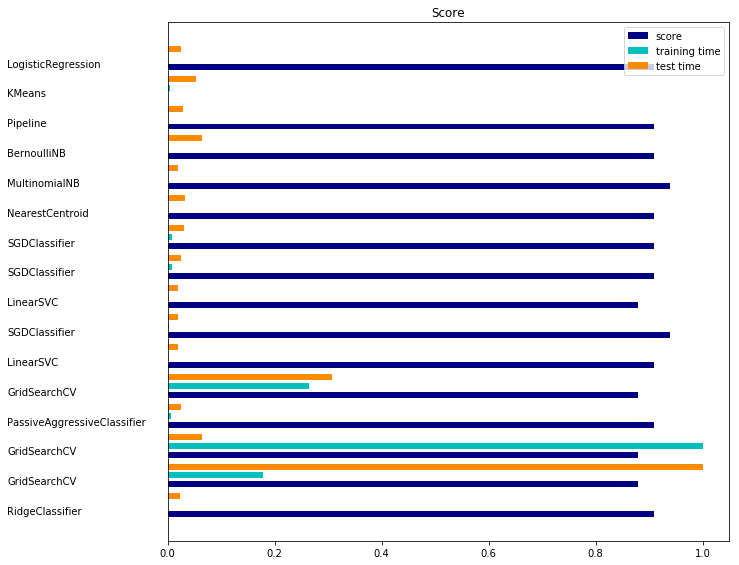

Evaluating Split 1
Train Size: 129
Test Size: 33
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 0.007s
test time:  0.000s
accuracy:   0.909
dimensionality: 1331
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.85      0.92      0.88        12
                   None       0.00      0.00      0.00         2

            avg / total       0.86      0.91      0.88        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 1  0  0 11  0]
 [ 0

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


train time: 2.363s
test time:  0.008s
accuracy:   0.879
classification report:
                         precision    recall  f1-score   support

            Make Update       0.82      1.00      0.90         9
          Setup Printer       1.00      0.80      0.89         5
      Shutdown Computer       0.83      1.00      0.91         5
Software Recommendation       0.92      0.92      0.92        12
                   None       0.00      0.00      0.00         2

            avg / total       0.83      0.88      0.85        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 1  4  0  0  0]
 [ 0  0  5  0  0]
 [ 1  0  0 11  0]
 [ 0  0  1  1  0]]

gridsearchmlp
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='cons

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


train time: 13.430s
test time:  0.001s
accuracy:   0.879
classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      0.80      0.89         5
Software Recommendation       0.79      0.92      0.85        12
                   None       0.00      0.00      0.00         2

            avg / total       0.83      0.88      0.85        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  4  1  0]
 [ 1  0  0 11  0]
 [ 0  0  0  2  0]]

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=50,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_s

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


train time: 3.813s
test time:  0.002s
accuracy:   0.909
classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.85      0.92      0.88        12
                   None       0.00      0.00      0.00         2

            avg / total       0.86      0.91      0.88        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 1  0  0 11  0]
 [ 0  0  0  2  0]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
train time: 0.003s
test time:  0.00

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels 

train time: 0.116s
test time:  0.000s
accuracy:   0.939
dimensionality: 1331
density: 0.500826

classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.92      0.92      0.92        12
                   None       1.00      0.50      0.67         2

            avg / total       0.94      0.94      0.94        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 1  0  0 11  0]
 [ 0  0  0  1  1]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.001s
test time:  0.000s
accuracy:   0.939
classification report:
                         precision    reca

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


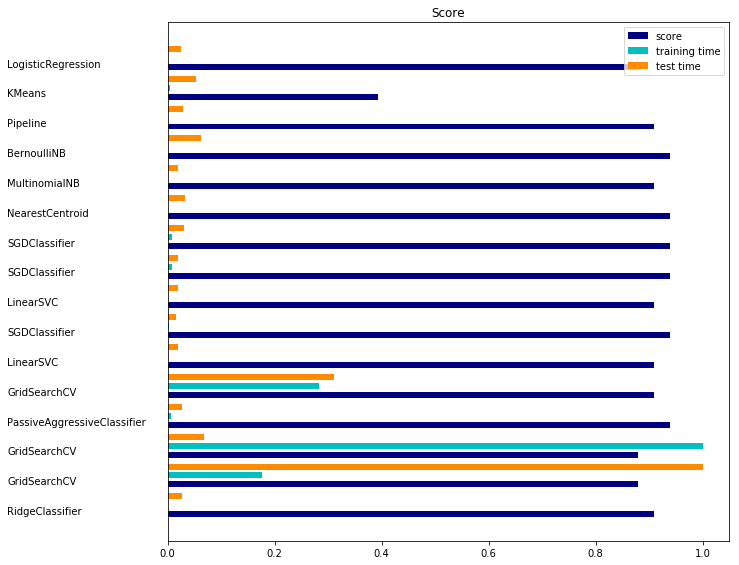

Evaluating Split 2
Train Size: 129
Test Size: 33
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 0.004s
test time:  0.000s
accuracy:   0.909
dimensionality: 1329
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.85      0.92      0.88        12
                   None       0.00      0.00      0.00         2

            avg / total       0.86      0.91      0.88        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 1  0  0 11  0]
 [ 0

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


train time: 2.362s
test time:  0.008s
accuracy:   0.848
classification report:
                         precision    recall  f1-score   support

            Make Update       0.75      1.00      0.86         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.82      0.75      0.78        12
                   None       0.00      0.00      0.00         2

            avg / total       0.81      0.85      0.82        33

confusion matrix:
[[9 0 0 0 0]
 [0 5 0 0 0]
 [0 0 5 0 0]
 [3 0 0 9 0]
 [0 0 0 2 0]]

gridsearchmlp
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_ra

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


train time: 13.431s
test time:  0.001s
accuracy:   0.848
classification report:
                         precision    recall  f1-score   support

            Make Update       0.82      1.00      0.90         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      0.80      0.89         5
Software Recommendation       0.77      0.83      0.80        12
                   None       0.00      0.00      0.00         2

            avg / total       0.81      0.85      0.82        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  4  1  0]
 [ 2  0  0 10  0]
 [ 0  0  0  2  0]]

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=50,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_s

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum numb

train time: 3.606s
test time:  0.003s
accuracy:   0.909
classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.85      0.92      0.88        12
                   None       0.00      0.00      0.00         2

            avg / total       0.86      0.91      0.88        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 1  0  0 11  0]
 [ 0  0  0  2  0]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
train time: 0.003s
test time:  0.00

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels 

train time: 0.116s
test time:  0.000s
accuracy:   0.879
dimensionality: 1329
density: 0.490444

classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       0.83      1.00      0.91         5
Software Recommendation       0.83      0.83      0.83        12
                   None       0.00      0.00      0.00         2

            avg / total       0.83      0.88      0.85        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 1  0  1 10  0]
 [ 0  0  0  2  0]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.001s
test time:  0.000s
accuracy:   0.909
classification report:
                         precision    reca

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set

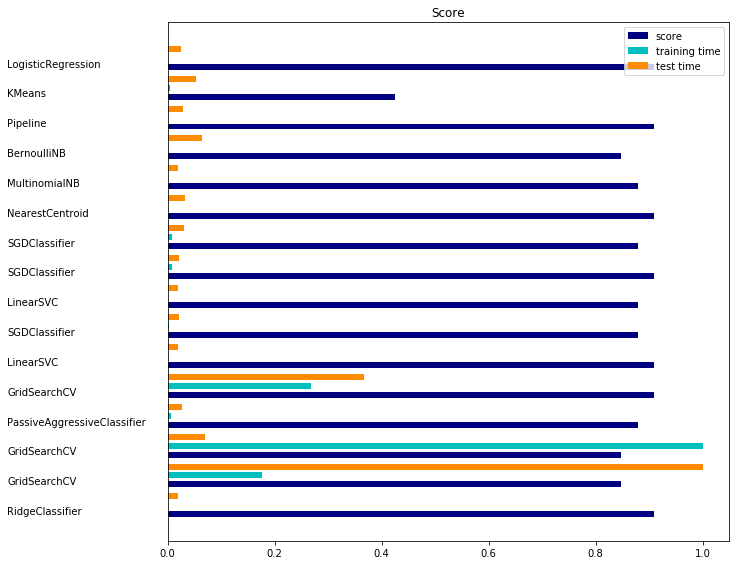

Evaluating Split 3
Train Size: 129
Test Size: 33
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 0.004s
test time:  0.000s
accuracy:   0.909
dimensionality: 1324
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       1.00      1.00      1.00         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      0.80      0.89         5
Software Recommendation       0.80      1.00      0.89        12
                   None       0.00      0.00      0.00         2

            avg / total       0.87      0.91      0.88        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  4  1  0]
 [ 0  0  0 12  0]
 [ 0

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


train time: 2.354s
test time:  0.008s
accuracy:   0.909
classification report:
                         precision    recall  f1-score   support

            Make Update       1.00      1.00      1.00         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       0.71      1.00      0.83         5
Software Recommendation       0.92      0.92      0.92        12
                   None       0.00      0.00      0.00         2

            avg / total       0.87      0.91      0.88        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  1 11  0]
 [ 0  0  1  1  0]]

gridsearchmlp
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='cons

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


train time: 13.441s
test time:  0.001s
accuracy:   0.848
classification report:
                         precision    recall  f1-score   support

            Make Update       1.00      1.00      1.00         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       0.67      0.80      0.73         5
Software Recommendation       0.83      0.83      0.83        12
                   None       0.00      0.00      0.00         2

            avg / total       0.83      0.85      0.84        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  4  1  0]
 [ 0  0  1 10  1]
 [ 0  0  1  1  0]]

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=50,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_s

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


train time: 3.788s
test time:  0.003s
accuracy:   0.879
classification report:
                         precision    recall  f1-score   support

            Make Update       1.00      1.00      1.00         9
          Setup Printer       1.00      0.80      0.89         5
      Shutdown Computer       1.00      0.80      0.89         5
Software Recommendation       0.75      1.00      0.86        12
                   None       0.00      0.00      0.00         2

            avg / total       0.85      0.88      0.85        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  4  0  1  0]
 [ 0  0  4  1  0]
 [ 0  0  0 12  0]
 [ 0  0  0  2  0]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
train time: 0.003s
test time:  0.00

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels 

train time: 0.114s
test time:  0.000s
accuracy:   0.879
dimensionality: 1324
density: 0.464653

classification report:
                         precision    recall  f1-score   support

            Make Update       1.00      1.00      1.00         9
          Setup Printer       0.83      1.00      0.91         5
      Shutdown Computer       1.00      0.80      0.89         5
Software Recommendation       0.85      0.92      0.88        12
                   None       0.00      0.00      0.00         2

            avg / total       0.86      0.88      0.87        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  4  1  0]
 [ 0  0  0 11  1]
 [ 0  1  0  1  0]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.000s
test time:  0.000s
accuracy:   0.879
classification report:
                         precision    reca

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


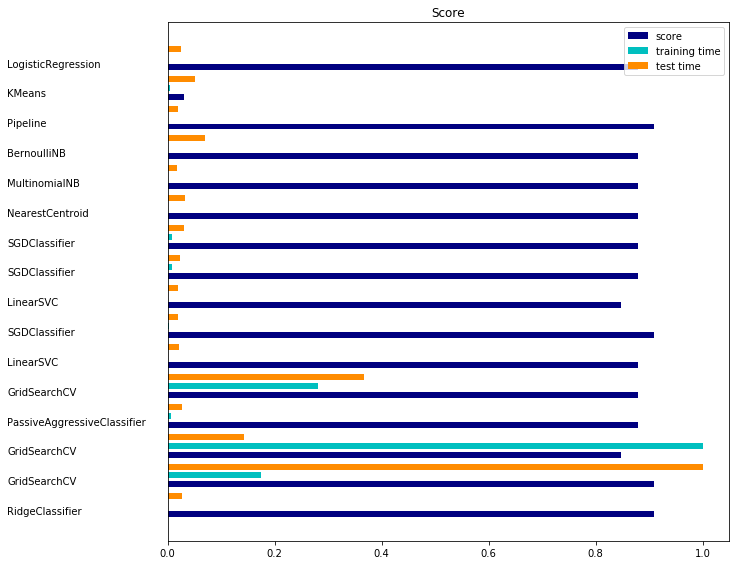

Evaluating Split 4
Train Size: 129
Test Size: 33
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 0.004s
test time:  0.000s
accuracy:   0.909
dimensionality: 1272
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.85      0.92      0.88        12
                   None       0.00      0.00      0.00         2

            avg / total       0.86      0.91      0.88        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 1  0  0 11  0]
 [ 0

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


train time: 2.296s
test time:  0.008s
accuracy:   0.818
classification report:
                         precision    recall  f1-score   support

            Make Update       0.69      1.00      0.82         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      0.80      0.89         5
Software Recommendation       0.82      0.75      0.78        12
                   None       0.00      0.00      0.00         2

            avg / total       0.79      0.82      0.79        33

confusion matrix:
[[9 0 0 0 0]
 [0 5 0 0 0]
 [1 0 4 0 0]
 [3 0 0 9 0]
 [0 0 0 2 0]]

gridsearchmlp
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_ra

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


train time: 13.503s
test time:  0.001s
accuracy:   0.818
classification report:
                         precision    recall  f1-score   support

            Make Update       0.75      1.00      0.86         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       0.80      0.80      0.80         5
Software Recommendation       0.82      0.75      0.78        12
                   None       0.00      0.00      0.00         2

            avg / total       0.77      0.82      0.79        33

confusion matrix:
[[9 0 0 0 0]
 [0 5 0 0 0]
 [1 0 4 0 0]
 [2 0 1 9 0]
 [0 0 0 2 0]]

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=50,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False)
train time: 0

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum numb

train time: 3.462s
test time:  0.002s
accuracy:   0.879
classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95         9
          Setup Printer       1.00      0.80      0.89         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.79      0.92      0.85        12
                   None       0.00      0.00      0.00         2

            avg / total       0.83      0.88      0.85        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  4  0  1  0]
 [ 0  0  5  0  0]
 [ 1  0  0 11  0]
 [ 0  0  0  2  0]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
train time: 0.003s
test time:  0.00

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels 

train time: 0.109s
test time:  0.000s
accuracy:   0.909
dimensionality: 1272
density: 0.480503

classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.85      0.92      0.88        12
                   None       0.00      0.00      0.00         2

            avg / total       0.86      0.91      0.88        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 1  0  0 11  0]
 [ 0  0  0  2  0]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.001s
test time:  0.000s
accuracy:   0.909
classification report:
                         precision    reca

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set

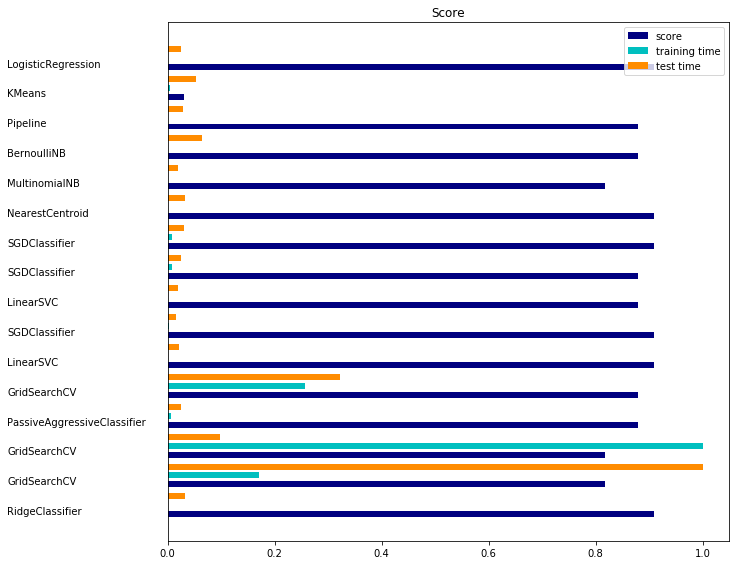

Evaluating Split 5
Train Size: 129
Test Size: 33
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 0.004s
test time:  0.000s
accuracy:   0.939
dimensionality: 1344
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       1.00      1.00      1.00         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.86      1.00      0.92        12
                   None       0.00      0.00      0.00         2

            avg / total       0.89      0.94      0.91        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  0 12  0]
 [ 0

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


train time: 2.389s
test time:  0.008s
accuracy:   0.909
classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       0.83      1.00      0.91         5
Software Recommendation       0.92      0.92      0.92        12
                   None       0.00      0.00      0.00         2

            avg / total       0.86      0.91      0.88        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 1  0  0 11  0]
 [ 0  0  1  1  0]]

gridsearchmlp
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='cons

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


train time: 13.641s
test time:  0.001s
accuracy:   0.879
classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       0.80      0.80      0.80         5
Software Recommendation       0.85      0.92      0.88        12
                   None       0.00      0.00      0.00         2

            avg / total       0.83      0.88      0.85        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  4  1  0]
 [ 1  0  0 11  0]
 [ 0  0  1  1  0]]

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=50,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_s

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum numb

train time: 3.538s
test time:  0.003s
accuracy:   0.939
classification report:
                         precision    recall  f1-score   support

            Make Update       1.00      1.00      1.00         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.86      1.00      0.92        12
                   None       0.00      0.00      0.00         2

            avg / total       0.89      0.94      0.91        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  0 12  0]
 [ 0  0  0  2  0]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
train time: 0.003s
test time:  0.00

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels 

train time: 0.116s
test time:  0.000s
accuracy:   0.909
dimensionality: 1344
density: 0.490327

classification report:
                         precision    recall  f1-score   support

            Make Update       1.00      1.00      1.00         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.85      0.92      0.88        12
                   None       0.00      0.00      0.00         2

            avg / total       0.88      0.91      0.90        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  0 11  1]
 [ 0  0  0  2  0]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.001s
test time:  0.000s
accuracy:   0.939
classification report:
                         precision    reca

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set

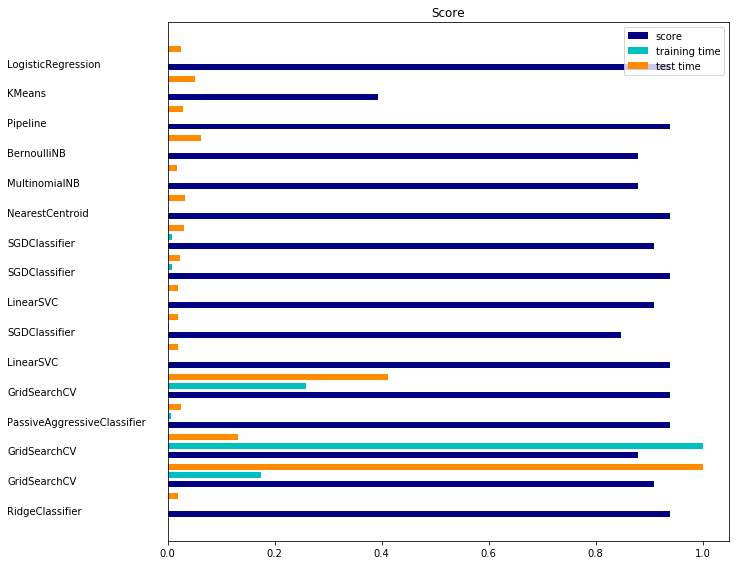

Evaluating Split 6
Train Size: 129
Test Size: 33
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 0.004s
test time:  0.000s
accuracy:   0.909
dimensionality: 1295
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       1.00      1.00      1.00         9
          Setup Printer       1.00      0.80      0.89         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.80      1.00      0.89        12
                   None       0.00      0.00      0.00         2

            avg / total       0.87      0.91      0.88        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  4  0  1  0]
 [ 0  0  5  0  0]
 [ 0  0  0 12  0]
 [ 0

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


train time: 2.304s
test time:  0.008s
accuracy:   0.848
classification report:
                         precision    recall  f1-score   support

            Make Update       0.75      1.00      0.86         9
          Setup Printer       1.00      0.80      0.89         5
      Shutdown Computer       1.00      0.80      0.89         5
Software Recommendation       0.85      0.92      0.88        12
                   None       0.00      0.00      0.00         2

            avg / total       0.82      0.85      0.82        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 1  4  0  0  0]
 [ 1  0  4  0  0]
 [ 1  0  0 11  0]
 [ 0  0  0  2  0]]

gridsearchmlp
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='cons

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


train time: 13.056s
test time:  0.001s
accuracy:   0.818
classification report:
                         precision    recall  f1-score   support

            Make Update       0.82      1.00      0.90         9
          Setup Printer       1.00      0.80      0.89         5
      Shutdown Computer       1.00      0.80      0.89         5
Software Recommendation       0.77      0.83      0.80        12
                   None       0.00      0.00      0.00         2

            avg / total       0.81      0.82      0.81        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  4  0  1  0]
 [ 1  0  4  0  0]
 [ 1  0  0 10  1]
 [ 0  0  0  2  0]]

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=50,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_s

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


train time: 3.484s
test time:  0.002s
accuracy:   0.909
classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95         9
          Setup Printer       1.00      0.80      0.89         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.86      1.00      0.92        12
                   None       0.00      0.00      0.00         2

            avg / total       0.86      0.91      0.88        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 1  4  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  0 12  0]
 [ 0  0  0  2  0]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
train time: 0.003s
test time:  0.00

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels 

train time: 0.111s
test time:  0.000s
accuracy:   0.909
dimensionality: 1295
density: 0.475676

classification report:
                         precision    recall  f1-score   support

            Make Update       1.00      1.00      1.00         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       0.83      1.00      0.91         5
Software Recommendation       0.85      0.92      0.88        12
                   None       0.00      0.00      0.00         2

            avg / total       0.86      0.91      0.88        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  1 11  0]
 [ 0  0  0  2  0]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.001s
test time:  0.000s
accuracy:   0.909
classification report:
                         precision    reca

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set

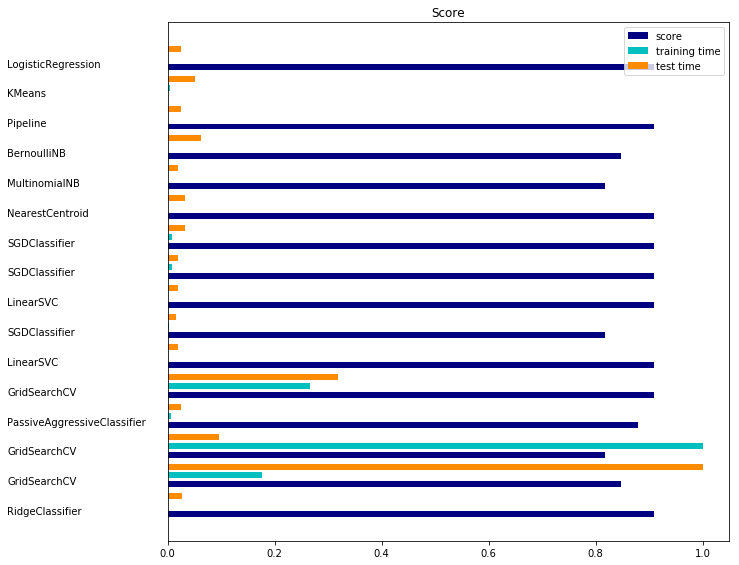

Evaluating Split 7
Train Size: 129
Test Size: 33
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 0.004s
test time:  0.000s
accuracy:   0.848
dimensionality: 1326
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.75      1.00      0.86         9
          Setup Printer       1.00      0.80      0.89         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.83      0.83      0.83        12
                   None       0.00      0.00      0.00         2

            avg / total       0.81      0.85      0.82        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 1  4  0  0  0]
 [ 0  0  5  0  0]
 [ 2  0  0 10  0]
 [ 0

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


train time: 2.358s
test time:  0.008s
accuracy:   0.788
classification report:
                         precision    recall  f1-score   support

            Make Update       0.64      1.00      0.78         9
          Setup Printer       1.00      0.80      0.89         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.80      0.67      0.73        12
                   None       0.00      0.00      0.00         2

            avg / total       0.77      0.79      0.76        33

confusion matrix:
[[9 0 0 0 0]
 [1 4 0 0 0]
 [0 0 5 0 0]
 [4 0 0 8 0]
 [0 0 0 2 0]]

gridsearchmlp
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_ra

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


train time: 12.988s
test time:  0.001s
accuracy:   0.818
classification report:
                         precision    recall  f1-score   support

            Make Update       0.69      1.00      0.82         9
          Setup Printer       1.00      0.80      0.89         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.82      0.75      0.78        12
                   None       0.00      0.00      0.00         2

            avg / total       0.79      0.82      0.79        33

confusion matrix:
[[9 0 0 0 0]
 [1 4 0 0 0]
 [0 0 5 0 0]
 [3 0 0 9 0]
 [0 0 0 2 0]]

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=50,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False)
train time: 0

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum numb

train time: 3.484s
test time:  0.002s
accuracy:   0.848
classification report:
                         precision    recall  f1-score   support

            Make Update       0.75      1.00      0.86         9
          Setup Printer       1.00      0.80      0.89         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.83      0.83      0.83        12
                   None       0.00      0.00      0.00         2

            avg / total       0.81      0.85      0.82        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 1  4  0  0  0]
 [ 0  0  5  0  0]
 [ 2  0  0 10  0]
 [ 0  0  0  2  0]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
train time: 0.003s
test time:  0.00

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels 

train time: 0.112s
test time:  0.000s
accuracy:   0.848
dimensionality: 1326
density: 0.471493

classification report:
                         precision    recall  f1-score   support

            Make Update       0.75      1.00      0.86         9
          Setup Printer       1.00      0.80      0.89         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.83      0.83      0.83        12
                   None       0.00      0.00      0.00         2

            avg / total       0.81      0.85      0.82        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 1  4  0  0  0]
 [ 0  0  5  0  0]
 [ 2  0  0 10  0]
 [ 0  0  0  2  0]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.001s
test time:  0.000s
accuracy:   0.848
classification report:
                         precision    reca

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set

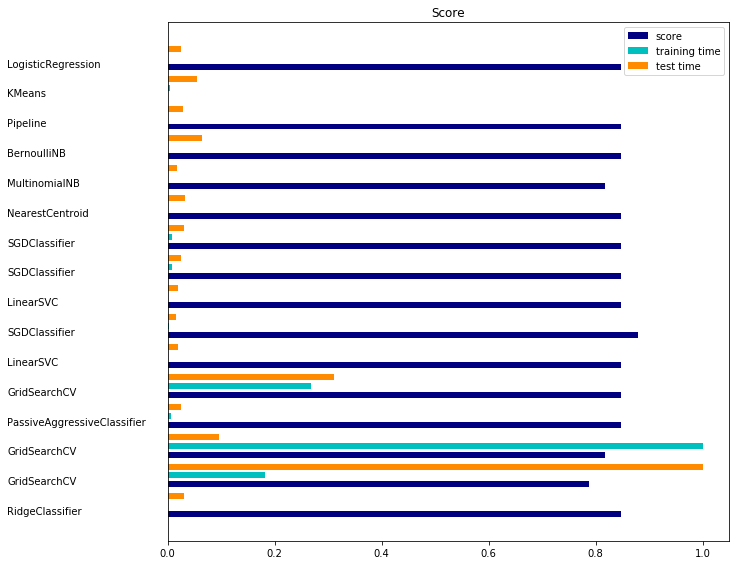

Evaluating Split 8
Train Size: 129
Test Size: 33
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 0.004s
test time:  0.000s
accuracy:   0.939
dimensionality: 1351
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       1.00      1.00      1.00         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.86      1.00      0.92        12
                   None       0.00      0.00      0.00         2

            avg / total       0.89      0.94      0.91        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  0 12  0]
 [ 0

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


train time: 2.398s
test time:  0.008s
accuracy:   0.879
classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95         9
          Setup Printer       0.83      1.00      0.91         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.83      0.83      0.83        12
                   None       0.00      0.00      0.00         2

            avg / total       0.83      0.88      0.85        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 1  1  0 10  0]
 [ 0  0  0  2  0]]

gridsearchmlp
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='cons

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


train time: 13.931s
test time:  0.001s
accuracy:   0.909
classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.85      0.92      0.88        12
                   None       0.00      0.00      0.00         2

            avg / total       0.86      0.91      0.88        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 1  0  0 11  0]
 [ 0  0  0  2  0]]

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=50,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_s

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum numb

train time: 3.502s
test time:  0.002s
accuracy:   0.939
classification report:
                         precision    recall  f1-score   support

            Make Update       1.00      1.00      1.00         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.86      1.00      0.92        12
                   None       0.00      0.00      0.00         2

            avg / total       0.89      0.94      0.91        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  0 12  0]
 [ 0  0  0  2  0]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
train time: 0.003s
test time:  0.00

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels 

train time: 0.117s
test time:  0.000s
accuracy:   0.939
dimensionality: 1351
density: 0.490007

classification report:
                         precision    recall  f1-score   support

            Make Update       1.00      1.00      1.00         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.86      1.00      0.92        12
                   None       0.00      0.00      0.00         2

            avg / total       0.89      0.94      0.91        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  0 12  0]
 [ 0  0  0  2  0]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.001s
test time:  0.000s
accuracy:   0.939
classification report:
                         precision    reca

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set

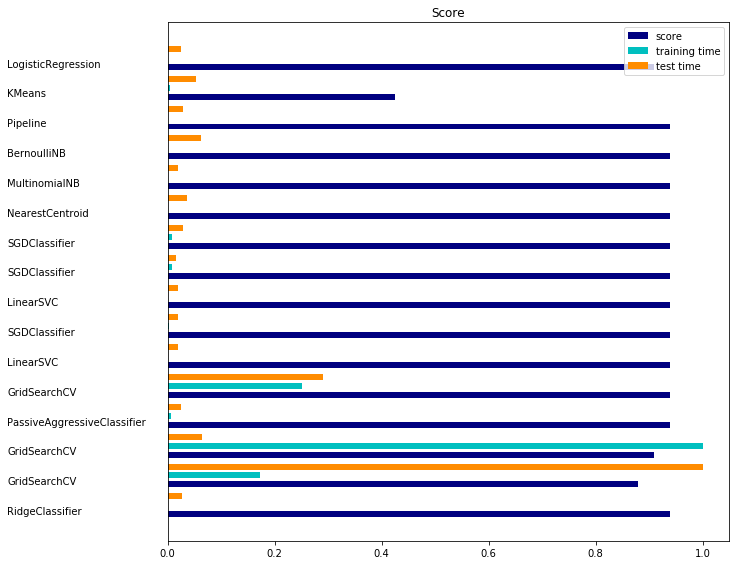

Evaluating Split 9
Train Size: 129
Test Size: 33
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 0.004s
test time:  0.000s
accuracy:   0.909
dimensionality: 1334
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.85      0.92      0.88        12
                   None       0.00      0.00      0.00         2

            avg / total       0.86      0.91      0.88        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 1  0  0 11  0]
 [ 0

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


train time: 2.378s
test time:  0.008s
accuracy:   0.909
classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       0.83      1.00      0.91         5
Software Recommendation       0.92      0.92      0.92        12
                   None       0.00      0.00      0.00         2

            avg / total       0.86      0.91      0.88        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 1  0  0 11  0]
 [ 0  0  1  1  0]]

gridsearchmlp
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='cons

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


train time: 13.956s
test time:  0.001s
accuracy:   0.909
classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       0.83      1.00      0.91         5
Software Recommendation       0.92      0.92      0.92        12
                   None       0.00      0.00      0.00         2

            avg / total       0.86      0.91      0.88        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 1  0  0 11  0]
 [ 0  0  1  1  0]]

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=50,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_s

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


train time: 3.644s
test time:  0.004s
accuracy:   0.909
classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       1.00      1.00      1.00         5
Software Recommendation       0.85      0.92      0.88        12
                   None       0.00      0.00      0.00         2

            avg / total       0.86      0.91      0.88        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 1  0  0 11  0]
 [ 0  0  0  2  0]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
train time: 0.003s
test time:  0.00

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels 

train time: 0.117s
test time:  0.000s
accuracy:   0.939
dimensionality: 1334
density: 0.492654

classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95         9
          Setup Printer       1.00      1.00      1.00         5
      Shutdown Computer       0.83      1.00      0.91         5
Software Recommendation       1.00      0.92      0.96        12
                   None       1.00      0.50      0.67         2

            avg / total       0.95      0.94      0.94        33

confusion matrix:
[[ 9  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  5  0  0]
 [ 1  0  0 11  0]
 [ 0  0  1  0  1]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.001s
test time:  0.000s
accuracy:   0.939
classification report:
                         precision    reca

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


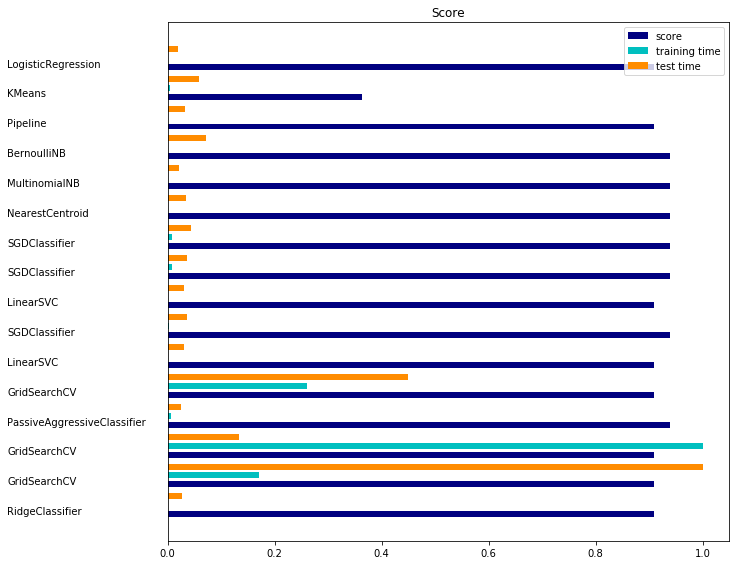

In [18]:
import matplotlib.pyplot as plt
for i_s, split in enumerate(splits):
    print("Evaluating Split {}".format(i_s))
    X_train, y_train, X_test, y_test, feature_names = get_X_andy_from_split(split)
    target_names = ["Make Update", "Setup Printer", "Shutdown Computer","Software Recommendation", "None"]
    print("Train Size: {}\nTest Size: {}".format(X_train.shape[0], X_test.shape[0]))
    results = []
    #alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
    parameters_mlp={'hidden_layer_sizes':[(100,50),(300,100,50),(200,100)]}
    parameters_RF={ "n_estimators" : [50,60,70],
           "min_samples_leaf" : [1, 2]}
    k_range = list(range(1, 11))
    parameters_knn = {'n_neighbors':k_range}
    knn=KNeighborsClassifier(n_neighbors=5)
    for clf, name in [  
            (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
            (GridSearchCV(knn,parameters_knn, cv=10),"gridsearchknn"),
            #(Perceptron(n_iter=50), "Perceptron"),
            (GridSearchCV(MLPClassifier(activation='tanh'),parameters_mlp, cv=10),"gridsearchmlp"),
           # (MLPClassifier(hidden_layer_sizes=(100, 50), activation="logistic", max_iter=300), "MLP"),
            #(MLPClassifier(hidden_layer_sizes=(300, 100, 50), activation="logistic", max_iter=500), "MLP"),
           # (MLPClassifier(hidden_layer_sizes=(300, 100, 50), activation="tanh", max_iter=500), "MLP"),
            (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
           # (KNeighborsClassifier(n_neighbors=1), "kNN"),
           # (KNeighborsClassifier(n_neighbors=3), "kNN"),
           # (KNeighborsClassifier(n_neighbors=5), "kNN"),
            #(KNeighborsClassifier(n_neighbors=10), "kNN"),
            (GridSearchCV(RandomForestClassifier(n_estimators=10),parameters_RF, cv=10),"gridsearchRF")
            #(RandomForestClassifier(n_estimators=10), "Random forest"),
            #(RandomForestClassifier(n_estimators=50), "Random forest")
    ]:
           
        print('=' * 80)
        print(name)
        results.append(benchmark(clf, X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names))
       # print('parameters')
       # print(clf.grid_scores_[0])
        #print('CV Validation Score')
       # print(clf.grid_scores_[0].cv_validation_scores)
       # print('Mean Validation Score')
       # print(clf.grid_scores_[0].mean_validation_score)
       # grid_mean_scores = [result.mean_validation_score for result in clf.grid_scores_]
       # print(grid_mean_scores)
       # plt.plot(k_range, grid_mean_scores)
       # plt.xlabel('Value of K for KNN')
       # plt.ylabel('Cross-Validated Accuracy')

    #parameters_Linearsvc = [{'C': [1, 10], 'gamma': [0.1,1.0]}]
    for penalty in ["l2", "l1"]:
        print('=' * 80)
        print("%s penalty" % penalty.upper())
        # Train Liblinear model
        #grid=(GridSearchCV(LinearSVC,parameters_Linearsvc, cv=10),"gridsearchSVC")
        #results.append(benchmark(LinearSVC(penalty=penalty), X_train, y_train, X_test, y_test, target_names,
                                # feature_names=feature_names))
        results.append(benchmark(LinearSVC(penalty=penalty, dual=False,tol=1e-3),
                                 X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names))

        # Train SGD model
        results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                               penalty=penalty),
                                 X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names))

    # Train SGD with Elastic Net penalty
    print('=' * 80)
    print("Elastic-Net penalty")
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty="elasticnet"),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))

    # Train NearestCentroid without threshold
    print('=' * 80)
    print("NearestCentroid (aka Rocchio classifier)")
    results.append(benchmark(NearestCentroid(),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))

    # Train sparse Naive Bayes classifiers
    print('=' * 80)
    print("Naive Bayes")
    results.append(benchmark(MultinomialNB(alpha=.01),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
    results.append(benchmark(BernoulliNB(alpha=.01),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))

    print('=' * 80)
    print("LinearSVC with L1-based feature selection")
    # The smaller C, the stronger the regularization.
    # The more regularization, the more sparsity.
    
# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
    results.append(benchmark(Pipeline([
                                  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                                                  tol=1e-3))),
                                  ('classification', LinearSVC(penalty="l2"))]),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
   # print(grid.grid_scores_)
   #KMeans clustering algorithm 
    print('=' * 80)
    print("KMeans")
    results.append(benchmark(KMeans(n_clusters=2, init='k-means++', max_iter=300,
                verbose=0, random_state=0, tol=1e-4),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
    
   
    
    print('=' * 80)
    print("LogisticRegression")
    #kfold = model_selection.KFold(n_splits=2, random_state=0)
    #model = LinearDiscriminantAnalysis()
    results.append(benchmark(LogisticRegression(C=1.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
    
    plot_results(results)
    
    